# Sudeste Module 3 Exam

### Instructions
Modify this notebook to compose your model. You may use additional `.py` files within this folder, `src/` for composing your framework.

It is discouraged to rename the `notebook.ipynb` for this particular task.

<div style="background-color: #f7f7f7; border: 1px solid #e1e1e1; border-radius: 5px; padding: 15px; max-width: 400px;">
    <h2 style="color: #333333; font-family: Arial, sans-serif;">Submitted by Group 6</h2>
    <ul style="color: #555555; font-family: Arial, sans-serif; font-size: 16px;">
        <li>Aguaviva, Christopher</li>
        <li>Baluyot, Kent Ryan</li>
        <li>Berida, Ronabelle</li>
    </ul>
</div>


### <span style="color:Orange;">  Table of Contents: </span>

I.    [Executive Summary](#summary)

II.   [Problem Statement](#problem)

III.  [Objective](#objective)

IV.   [Data Cleaning](#datacleaning)

V.    [Visualizations and EDA](#eda)

VI.   [ARIMA Model](#arima)

VII.  [Deep Learning Model](#dl)
  
VIII. [Comparison](#comparison)

IX.   [Conclusion and Recommendations](#conclusion)

***

## <span style="color:Orange;"> I. Executive Summary </span>  <a name="summary"></a>
`edit contents`

## <span style="color:Orange;"> II. Problem Statement </span>  <a name="problem"></a>  
`edit contents`

## <span style="color:Orange;"> III. Objective </span>  <a name="objective"></a>  
`edit contents`

## <span style="color:Orange;"> IV. Data Cleaning </span>  <a name="datacleaning"></a>  

Importing Modules

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import warnings
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
import tensorflow as tf

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from datetime import datetime

pd.set_option('display.max_columns', 40)   # displays max columns of the DataFrame 

### Processing the data
In this dataset, the group opt to only take the latest 30 days in the dataset as the dataset are divided into hours instead of day. In this case, the dataset is filtered, only taking the rows that are in the month of September 2016.

In [2]:
# Chunking the dataset for faster processing of data
filepath = "C:/Users/User/Downloads/sudeste.csv"
chunk_size = 30000 
df = pd.DataFrame()

# Iterate over chunks of the file and process each chunk
for chunk in pd.read_csv(filepath, parse_dates=['mdct', 'date'], chunksize=chunk_size):
    filtered_chunk = chunk[chunk['date'] >= '2016-01-01']
    df = pd.concat([df, filtered_chunk])

In [6]:
# Only showing the columns with null values
missing_values = df.isnull().sum()
missing_columns = missing_values[missing_values > 0]  
if not missing_columns.empty:
    print('Columns with missing values:')
    print(missing_columns)
else:
    print('No missing values in any columns.')

Columns with missing values:
prcp    668060
gbrd    328121
temp        11
dewp        64
tmax        10
dmax        41
tmin         5
dmin       103
wdsp     75367
gust     25152
dtype: int64


In [3]:
# Filling missing values with the average of the previous and next non-null values
# This is done ONLY to the relevant columns

df['prcp'] = df['prcp'].fillna((df['prcp'].ffill() + df['prcp'].bfill()) / 2)
df['wdsp'] = df['wdsp'].fillna((df['wdsp'].ffill() + df['wdsp'].bfill()) / 2)
df['temp'] = df['temp'].fillna((df['temp'].ffill() + df['temp'].bfill()) / 2) 

## <span style="color:Orange;"> V. Visualizations and EDA </span>  <a name="eda"></a>  

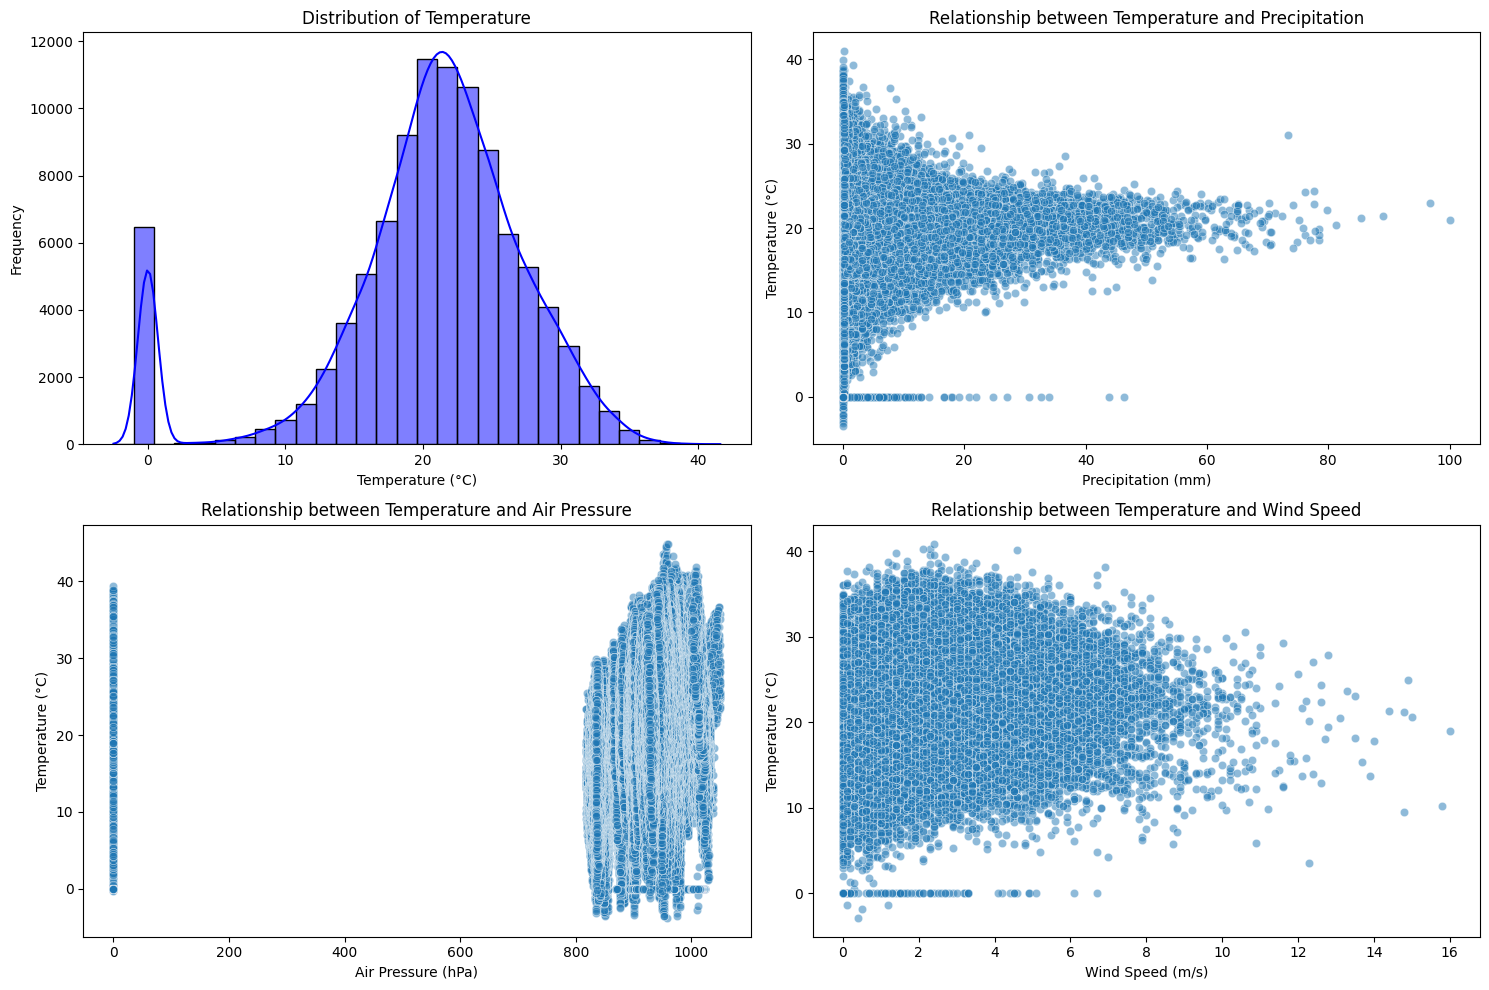

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Visualize the distribution of temperature
sns.histplot(df['temp'].sample(n=100000), bins=30, kde=True, color='blue', ax=axes[0, 0])  # Sample a subset of data for visualization
axes[0, 0].set_title('Distribution of Temperature')
axes[0, 0].set_xlabel('Temperature (°C)')
axes[0, 0].set_ylabel('Frequency')

# Relationship between Temperature and Precipitation
sns.scatterplot(x='prcp', y='temp', data=df, alpha=0.5, ax=axes[0, 1])
axes[0, 1].set_title('Relationship between Temperature and Precipitation')
axes[0, 1].set_xlabel('Precipitation (mm)')
axes[0, 1].set_ylabel('Temperature (°C)')

# Relationship between Temperature and Air Pressure
sns.scatterplot(x='stp', y='temp', data=df, alpha=0.5, ax=axes[1, 0])
axes[1, 0].set_title('Relationship between Temperature and Air Pressure')
axes[1, 0].set_xlabel('Air Pressure (hPa)')
axes[1, 0].set_ylabel('Temperature (°C)')

# Relationship between Temperature and Wind Speed
sns.scatterplot(x='wdsp', y='temp', data=df.sample(n=100000), alpha=0.5, ax=axes[1, 1])  # Sample a subset of data for visualization
axes[1, 1].set_title('Relationship between Temperature and Wind Speed')
axes[1, 1].set_xlabel('Wind Speed (m/s)')
axes[1, 1].set_ylabel('Temperature (°C)')

plt.tight_layout()
plt.show()

**The first graph** shows the distribution of temperature. The x-axis represents temperature in degrees Celsius (°C), and the y-axis represents frequency. The graph shows that the most frequent temperatures fall between 10°C and 20°C.

**The second graph** shows the relationship between temperature and precipitation. The x-axis represents temperature in degrees Celsius (°C), and the y-axis represents precipitation in millimeters (mm). The graph shows that there is a positive correlation between temperature and precipitation. This means that as the temperature increases, the precipitation also increases.

**The third graph** shows the relationship between temperature and air pressure. The x-axis represents temperature in degrees Celsius (°C), and the y-axis represents air pressure in hectopascals (hPa). The graph shows that there is an inverse correlation between temperature and air pressure. This means that as the temperature increases, the air pressure decreases.

**The fourth graph** shows the relationship between temperature and wind speed. The x-axis represents temperature in degrees Celsius (°C), and the y-axis represents wind speed in meters per second (m/s). The graph shows that there is a weak positive correlation between temperature and wind speed. This means that as the temperature increases, the wind speed also increases, but the correlation is weak.`

In [20]:
# List of all the weather stations/cities
df['wsnm'].unique()

array(['SÃO GONÇALO', 'VITÓRIA', 'SANTA TERESA', 'LINHARES',
       'ALFREDO CHAVES', 'SÃO MATEUS', 'ALEGRE', 'PRES. KENNEDY',
       'NOVA VENECIA', 'AFONSO CLAUDIO', 'BARBACENA', 'ARAXÁ',
       'MONTES CLAROS', 'UBERLÂNDIA', 'ALMENARA', 'MONTE VERDE', 'VIÇOSA',
       'TIMÓTEO', 'ITUIUTABA', 'OURO BRANCO', 'S.J.DEL REI', 'VARGINHA',
       'PASSOS', 'MURIAÉ', 'JUÍZ DE FORA', 'CAMPINA VERDE',
       'CONC. DAS ALAGOAS', 'BELO HOR. (PAMPULHA)', 'SERRA DOS AIMORES',
       'PATROCÍNIO', 'FORMIGA', 'SACRAMENTO', 'MONTALVANIA',
       'TEÓFILO OTONI', 'TRÊS MARIAS', 'PASSA QUATRO', 'CALDAS',
       'MARIA DA FÉ', 'GOVERNADOR VALADARES', 'GUANHÃES', 'AIMORES',
       'FLORESTAL', 'DORES DO INDAIÁ', 'DIAMANTINA', 'CURVELO',
       'MOCAMBINHO', 'MANTENA', 'CAPELINHA', 'UNAI', 'ESPINOSA',
       'BURITIS', 'PIRAPORA', 'GUARDA-MOR', 'SÃO ROMÃO', 'CHAPADA GAÚCHA',
       'ÁGUAS VERMELHAS', 'ITAOBIM', 'RIO PARDO DE MINAS', 'SALINAS',
       'JOÃO PINHEIRO', 'CARATINGA', 'IBIRITÈ (ROLA MOÇA)', 

Since there are numerous cities and it would not be plausible to combine them due to different locations. The group intends to plotting the time series using SACRAMENTO city (with weather id station #333).

In [4]:
chosen_city = df[df["wsnm"] == "SACRAMENTO"]
chosen_city.reset_index(drop=True, inplace=True)

In [22]:
chosen_city.head(3)

,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,yr,mo,da,hr,prcp,stp,smax,smin,gbrd,temp,dewp,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
0,333,SACRAMENTO,913.0,-19.875271,-47.434102,A525,Sacramento,MG,2016-01-01 00:00:00,2016-01-01,2016,1,1,0,2.5,912.2,912.2,911.6,52.703,22.3,18.9,23.4,18.9,22.3,17.7,81.0,81.0,70.0,1.1,49.0,3.4
1,333,SACRAMENTO,913.0,-19.875271,-47.434102,A525,Sacramento,MG,2016-01-01 01:00:00,2016-01-01,2016,1,1,1,2.5,912.9,912.9,912.2,52.703,22.3,18.8,22.5,19.1,22.2,18.7,80.0,82.0,80.0,0.2,139.0,1.5
2,333,SACRAMENTO,913.0,-19.875271,-47.434102,A525,Sacramento,MG,2016-01-01 02:00:00,2016-01-01,2016,1,1,2,2.5,912.8,913.0,912.8,52.703,22.1,18.7,22.5,18.8,22.1,18.3,81.0,81.0,78.0,0.7,184.0,1.4


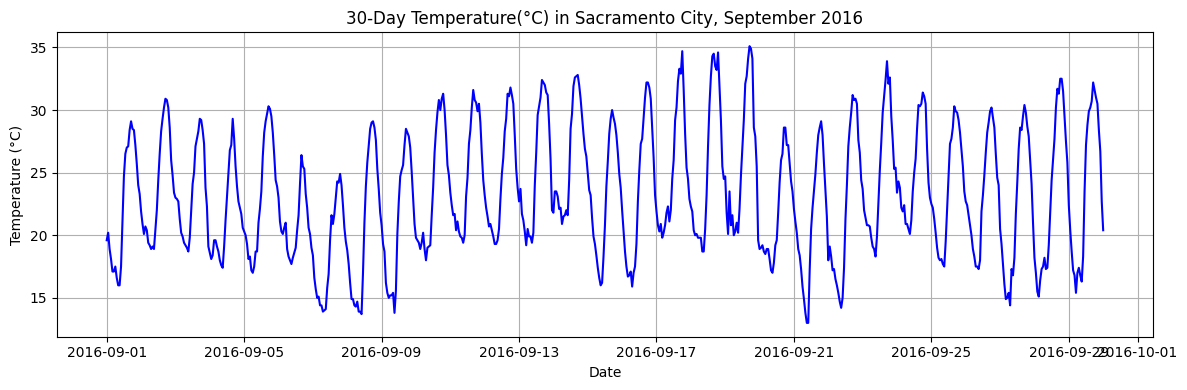

In [7]:
# Creating a time series plot of 30 days of temperature
# Filter the DataFrame to include only dates from August 1 to the last day of August
sept_data = chosen_city[(chosen_city['mdct'] >= '2016-09-01') & (chosen_city['mdct'] <= '2016-09-30')]

plt.figure(figsize=(12, 4))
plt.plot(sept_data['mdct'], sept_data['temp'], color='blue', linestyle='-')
plt.title('30-Day Temperature(°C) in Sacramento City, September 2016')                             
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()

September 2016, Sacramento City, California, **Average daily temperature** is displayed on the graph. September 1, 2016, to September 30, 2016 is the date range displayed on the x-axis. Degree Celsius (°C) is displayed on the y-axis as the temperature.A high of about 32°C and a low of about 15°C are seen for the average daily temperature throughout the month. The average monthly temperature appears to be about 25°C, although it is hard to tell from this graph.

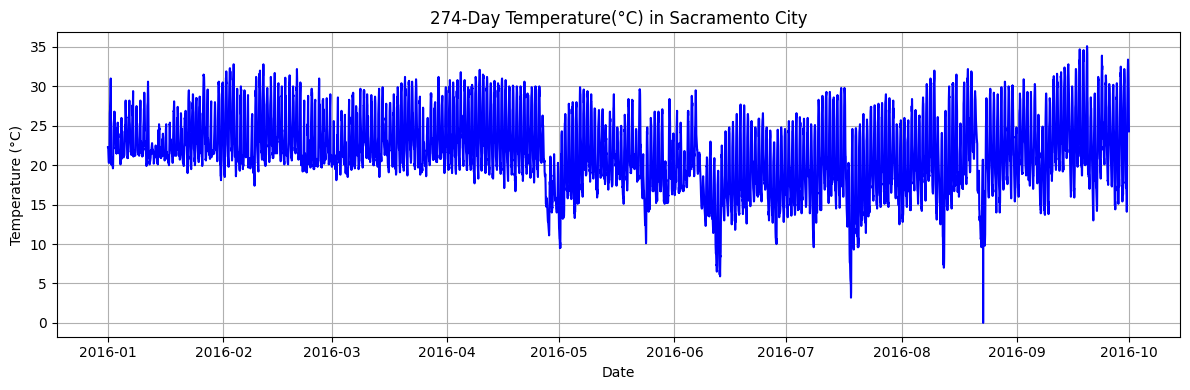

In [25]:
# Create a time series plot of 9 months of temperature
plt.figure(figsize=(12, 4))
plt.plot(chosen_city['mdct'], chosen_city['temp'], color='blue', linestyle='-')
plt.title('274-Day Temperature(°C) in Sacramento City')                                   #274 days as the year 2016 is a leap year
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()

The temperature average for **Sacramento City, California in 2016** is seen on the graph. The graph indicates that Sacramento has a warm Mediterranean climate, with warm, dry summers and moderate, wet winters. The x-axis displays the month, and the y-axis displays the temperature in degrees Celsius (°C). The average temperature is around 10°C (50°F) in December and January and reaches its maximum in July and August, when it is approximately 27°C (80°F).

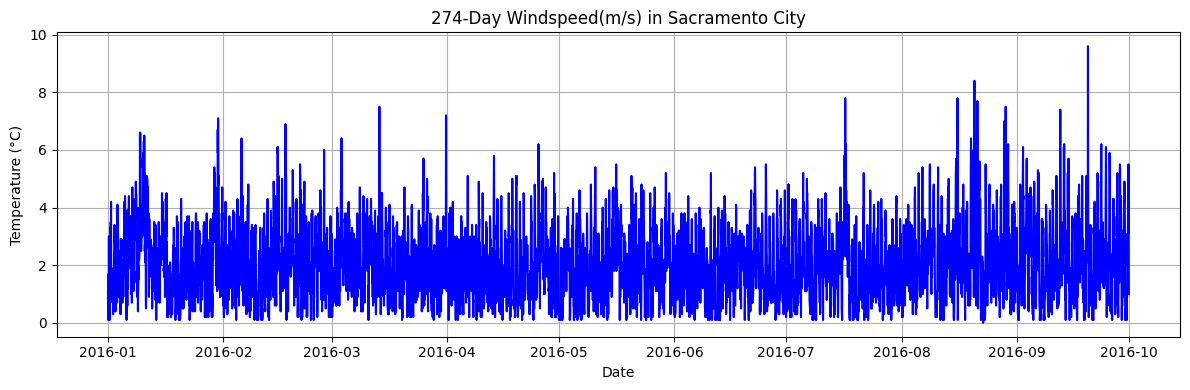

In [110]:
# Create a time series plot of temperature
plt.figure(figsize=(12, 4))
plt.plot(chosen_city['mdct'], chosen_city['wdsp'], color='blue', linestyle='-')
plt.title('274-Day Windspeed(m/s) in Sacramento City')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()

 **“274-Day Windspeed(m/s) in Sacramento City,”** This shows the windspeed in meters per second over a period from January to October 2016. The blue vertical lines represent daily windspeeds, with taller lines indicating higher speeds. 

## <span style="color:Orange;"> VI. ARIMA Model </span>  <a name="arima"></a>  
In this section, we'll build an ARIMA (AutoRegressive Integrated Moving Average) model to forecast temperature based on historical weather data. We'll start by preparing the data for modeling, then train the ARIMA model, and finally evaluate its performance. First, the group will find the best values for the ARIMA model by exploring different combinations in parameters (p, d, q).

In [82]:
p = d = q = range(0,2)

# Generating all different combinations of parameter
pdq = list(itertools.product(p, d, q))

# Generating all different combinations
seasonal_pdq = [(x[0], x[1], x[2], 9) for x in list(itertools.product(p, d, q))]

### Finding the best parameter
The group will use the Akaike Information Criterion value (AIC), which measures how well a model fits the data. The group finds the model that yields the lowest AIC value.

In [8]:
sacramento_temp = chosen_city[['mdct', 'temp']]
sacramento_temp.set_index('mdct', inplace=True)

In [9]:
sacramento_temp

,temp
mdct,
2016-01-01 00:00:00,22.3
2016-01-01 01:00:00,22.3
2016-01-01 02:00:00,22.1
2016-01-01 03:00:00,21.5
2016-01-01 04:00:00,20.8
...,...
2016-09-30 19:00:00,31.6
2016-09-30 20:00:00,31.2
2016-09-30 21:00:00,29.3


In [84]:
warnings.filterwarnings('ignore')     # remove the warnings

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(sacramento_temp, order=param, 
            seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)

            results = model.fit()
            print(f'ARIMA{param} * {param_seasonal}9 - AIC:{results.aic}')          # 9 since there are 9 months involved
        except:
            continue

ARIMA(0, 0, 0) * (0, 0, 0, 9)9 - AIC:59493.49768008627
ARIMA(0, 0, 0) * (0, 0, 1, 9)9 - AIC:52606.465761521205
ARIMA(0, 0, 0) * (0, 1, 0, 9)9 - AIC:44302.0444574341
ARIMA(0, 0, 0) * (0, 1, 1, 9)9 - AIC:38240.65893488921
ARIMA(0, 0, 0) * (1, 0, 0, 9)9 - AIC:44147.67445234129
ARIMA(0, 0, 0) * (1, 0, 1, 9)9 - AIC:38304.538554579936
ARIMA(0, 0, 0) * (1, 1, 0, 9)9 - AIC:40637.4779897821
ARIMA(0, 0, 0) * (1, 1, 1, 9)9 - AIC:37277.32148895976
ARIMA(0, 0, 1) * (0, 0, 0, 9)9 - AIC:50774.15739850007
ARIMA(0, 0, 1) * (0, 0, 1, 9)9 - AIC:45112.96479702018
ARIMA(0, 0, 1) * (0, 1, 0, 9)9 - AIC:37248.11106045674
ARIMA(0, 0, 1) * (0, 1, 1, 9)9 - AIC:31250.971255805245
ARIMA(0, 0, 1) * (1, 0, 0, 9)9 - AIC:37071.40300794167
ARIMA(0, 0, 1) * (1, 0, 1, 9)9 - AIC:31305.953868041044
ARIMA(0, 0, 1) * (1, 1, 0, 9)9 - AIC:33706.15716790526
ARIMA(0, 0, 1) * (1, 1, 1, 9)9 - AIC:30471.66923802066
ARIMA(0, 1, 0) * (0, 0, 0, 9)9 - AIC:23891.865630865766
ARIMA(0, 1, 0) * (0, 0, 1, 9)9 - AIC:23117.961132224664
ARIMA(

#### Fitting the model to data with the best parameters
The last AIC line has the lowest AIC value (22023.022) out of all the listed parameters. Thus, we will take `ARIMA(1, 1, 1), (1, 1, 1, 9)`

In [212]:
best_model = sm.tsa.statespace.SARIMAX(sacramento_temp, order=(1,1,1), seasonal_order=(1, 1, 1, 9),
                                       enforce_stationarity=False, enforce_invertibility=False)

results = best_model.fit()
results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.6294,0.019,32.369,0.000,0.591,0.668
ma.L1,-0.2547,0.018,-13.833,0.000,-0.291,-0.219
ar.S.L9,-0.1402,0.011,-12.840,0.000,-0.162,-0.119
ma.S.L9,-1.0011,0.004,-249.245,0.000,-1.009,-0.993
sigma2,1.6659,0.012,143.990,0.000,1.643,1.689


Each weight of the models has a p-value (P>|z|) less than 0.05, that is why we'll retain the models.

### Validating Forecast
First, we will determine the accuracy and errors of the actual and predicted values of a present data by comparing the actual and predicted values of the last 7 days in September 2016. Later on, the created model will be used to forecast the unknown data (since the dataset is only up until September 20, 2016). The created model will predict the temperature of the incoming 14 days starting from October 01, 2016.

In [216]:
# Confidence Interval of the dataset
pred = results.get_prediction(start=pd.to_datetime('2016-09-24 00:00:00'), dynamic=False)
pred_conf_i = pred.conf_int()
pred_conf_i

,lower temp,upper temp
2016-09-24 00:00:00,22.454499,27.521080
2016-09-24 01:00:00,20.049384,25.115964
2016-09-24 02:00:00,21.803316,26.869893
2016-09-24 03:00:00,21.350148,26.416725
2016-09-24 04:00:00,18.886873,23.953451
...,...,...
2016-09-30 19:00:00,29.835919,34.902428
2016-09-30 20:00:00,27.671428,32.737935
2016-09-30 21:00:00,28.115188,33.181695
2016-09-30 22:00:00,26.025403,31.091910


#### Actual vs Predicted Values
Predicting the values on the last 9 days of September. <span style="color:Red;"> temp </span> is the <span style="color:Red;">actual temperature </span>, while <span style="color:Blue;"> Pred_temp </span> is the <span style="color:Blue;">predicted temperature </span>. This step evaluates the mean squared error of the model.

In [217]:
y_forecasted = pred.predicted_mean
y_truth = sacramento_temp['2016-09-24 00:00:00':]
y_truth['Pred_temp'] = y_forecasted
y_truth

,temp,Pred_temp
mdct,,
2016-09-24 00:00:00,23.4,24.987789
2016-09-24 01:00:00,24.3,22.582674
2016-09-24 02:00:00,23.8,24.336605
2016-09-24 03:00:00,22.2,23.883437
2016-09-24 04:00:00,21.9,21.420162
...,...,...
2016-09-30 19:00:00,31.6,32.369174
2016-09-30 20:00:00,31.2,30.204682
2016-09-30 21:00:00,29.3,30.648442


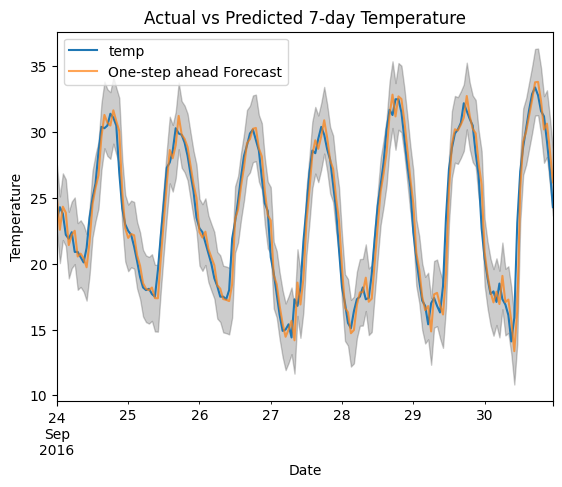

In [219]:
# Visualizing the forecast
ax = sacramento_temp['2016-09-24 00:00:00':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_conf_i.index, pred_conf_i.iloc[:,0], pred_conf_i.iloc[:,1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
plt.title('Actual vs Predicted 7-day Temperature')
plt.legend()
plt.show()

The x-axis shows the month, and the y-axis on the left side is in degrees Fahrenheit (°F) for temperature. The y-axis on the right side is in inches for precipitation and in hours for sunshine.

The graph shows that San Diego has a warm Mediterranean climate, with warm, dry summers and mild, wet winters:

**The average high temperature** is highest in August, at around 82°F (28°C), and lowest in December and January, at around 64°F (18°C).

**The average low temperature** is highest in August, at around 68°F (20°C), and lowest in December and January, at around 46°F (8°C).

**San Diego receives most of its rain** during the winter months. The average monthly precipitation is highest in February, at around 2.5 inches (6.3 cm), and lowest in July and August, at around 0.1 inches (0.25 cm).

**San Diego gets the most sunshine hours** in the summer months. The average monthly sunshine is highest in July, at around 11 hours, and lowest in December, at around 7 hours.

#### Calculating Errors

In [63]:
mse = mean_squared_error(y_truth['temp'], y_truth['Pred_temp'])
rmse = np.sqrt(mse)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

Mean Squared Error: 1.83692662660533
Root Mean Squared Error: 1.3553326627088016


### Future Predictions

In [92]:
pred_future =  results.get_forecast(steps=336)        # Predicting 14 days ahead in the future
pred_conf_i = pred_future.conf_int()                  # Confidence interval of the forecasts

# Storing the predicted future values
future_df = pd.DataFrame(pred_future.predicted_mean)
future_df.columns = ['future_pred']

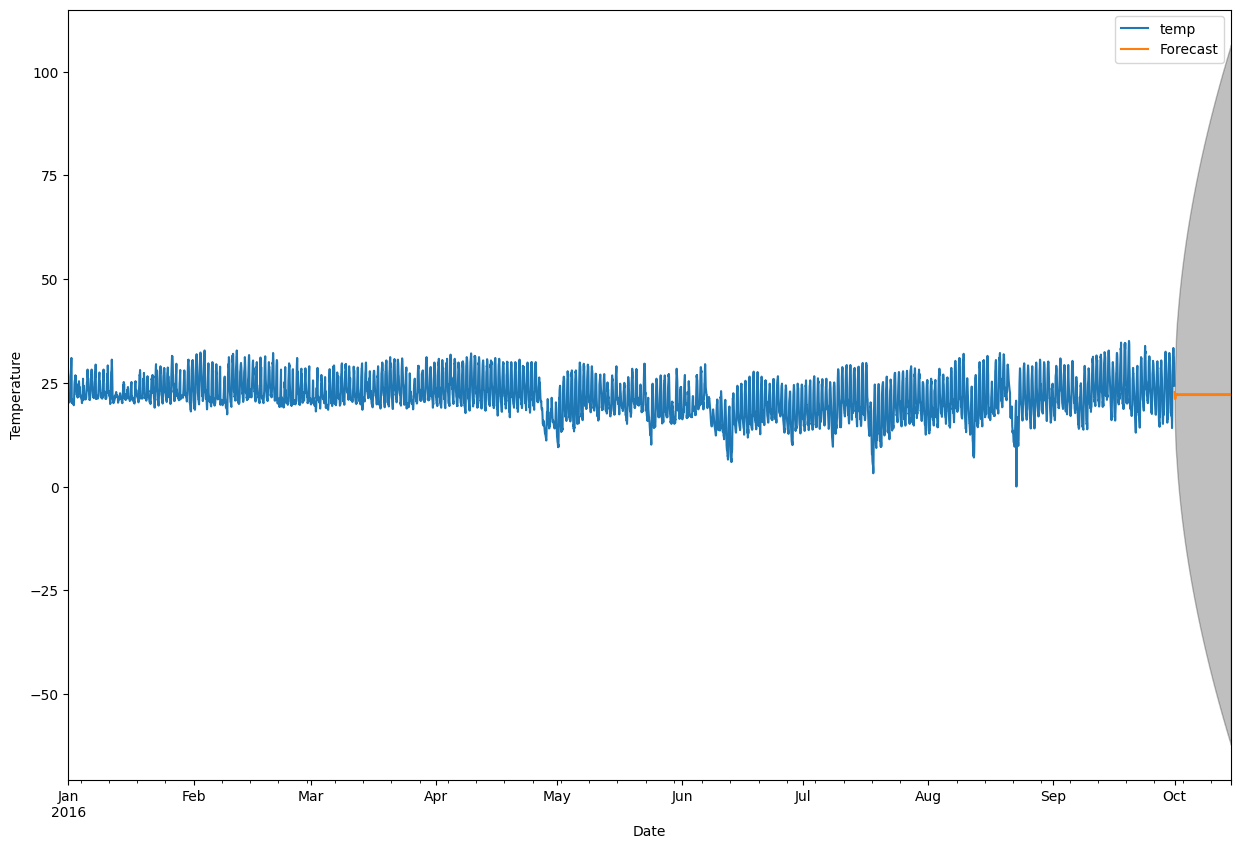

In [109]:
# Visualizing the predictions 7 days ahead
ax = sacramento_temp.plot(label='Observed', figsize=(15,10))
pred_future.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_conf_i.index, pred_conf_i.iloc[:,0], pred_conf_i.iloc[:,1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
plt.legend()
plt.show()

The red line represents the zero amplitude or resting position of the sound wave. The distance between the peak of the wave and the red line represents the positive amplitude of the sound wave. The distance between the trough of the wave and the red line represents the negative amplitude of the sound wave.

The amplitude of a sound wave is related to the loudness of the sound.  A sound wave with a higher amplitude will be perceived as louder than a sound wave with a lower amplitude.

The space between peaks or troughs in a sound wave is called the wavelength. The wavelength is inversely proportional to the frequency of the sound wave. Frequency is measured in Hertz (Hz). A higher frequency sound wave will have a shorter wavelength than a lower frequency sound wave.  The frequency of a sound wave is related to the pitch of the sound. A sound wave with a higher frequency will be perceived as having a higher pitch than a sound wave with a lower frequency.

## <span style="color:Orange;"> VII. Deep Learning Model </span>  <a name="dl"></a>  
We implement deep learning models for temperature prediction and compare their performance with the ARIMA model. We'll also include a comparison between the results of the ARIMA model and deep learning models, assessing which model performs better in prediction.

In [15]:
# Reshape the Series into a DataFrame with a single column
sacramento_temp_reshaped = sacramento_temp['temp'].values.reshape(-1, 1)

# Normalize features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(sacramento_temp_reshaped)

# Convert the scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, index=sacramento_temp.index, columns=['scaled_temp'])

In [22]:
# Sequence length and features
time_step = 24                             # Predicting after 24 hours/a day
num_features = len(columns)

In [25]:
scaled_df

,scaled_temp
mdct,
2016-01-01 00:00:00,0.635328
2016-01-01 01:00:00,0.635328
2016-01-01 02:00:00,0.629630
2016-01-01 03:00:00,0.612536
2016-01-01 04:00:00,0.592593
...,...
2016-09-30 19:00:00,0.900285
2016-09-30 20:00:00,0.888889
2016-09-30 21:00:00,0.834758


Preparing data for LSTM input

In [92]:
def create_lstm_dataset(data, time_step=1):
    X = []
    y = []

    for i in range(len(data) - time_step):
        seq = data[i:(i+time_step), 0]
        label = data[i+time_step, 0] 
        X.append(seq)
        y.append(label)

    return np.array(X), np.array(y)

time_step = 24
train_data_np = train_data.to_numpy()
test_data_np = test_data.to_numpy()

train_X, train_y = create_lstm_dataset(train_data_np)
test_X, test_y = create_lstm_dataset(test_data_np)

In [120]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (556, 24, 6)
Shape of X_test: (140, 24, 6)
Shape of y_train: (556,)
Shape of y_test: (140,)


#### Creating LSTM Model

In [145]:
# Creating the LSTM Model
model = tf.keras.models.Sequential([tf.keras.layers.LSTM(units=128, input_shape=(time_step, 1), return_sequences=True),
                                   tf.keras.layers.Dropout(0.2),

                                   tf.keras.layers.LSTM(units=64, return_sequences=True),
                                   tf.keras.layers.Dropout(0.2),

                                   tf.keras.layers.Dense(units=1)
])

c:\Users\User\anaconda3\envs\NEW_ENV_NAME\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [146]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 24, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 24, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 24, 1)          │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

In [147]:
history = model.fit(train_X, train_y, epochs=20, batch_size=16, validation_split=0.2, verbose=2)

Epoch 1/20
263/263 - 6s - 23ms/step - accuracy: 4.7540e-04 - loss: 0.0525 - val_accuracy: 0.0000e+00 - val_loss: 0.0200
Epoch 2/20
263/263 - 1s - 4ms/step - accuracy: 2.3770e-04 - loss: 0.0211 - val_accuracy: 0.0000e+00 - val_loss: 0.0193
Epoch 3/20
263/263 - 1s - 5ms/step - accuracy: 2.3770e-04 - loss: 0.0202 - val_accuracy: 0.0000e+00 - val_loss: 0.0199
Epoch 4/20
263/263 - 1s - 5ms/step - accuracy: 2.3770e-04 - loss: 0.0200 - val_accuracy: 0.0000e+00 - val_loss: 0.0190
Epoch 5/20
263/263 - 1s - 5ms/step - accuracy: 2.3770e-04 - loss: 0.0198 - val_accuracy: 0.0000e+00 - val_loss: 0.0198
Epoch 6/20
263/263 - 1s - 4ms/step - accuracy: 2.3770e-04 - loss: 0.0198 - val_accuracy: 0.0000e+00 - val_loss: 0.0195
Epoch 7/20
263/263 - 1s - 5ms/step - accuracy: 2.3770e-04 - loss: 0.0198 - val_accuracy: 0.0000e+00 - val_loss: 0.0191
Epoch 8/20
263/263 - 1s - 5ms/step - accuracy: 2.3770e-04 - loss: 0.0196 - val_accuracy: 0.0000e+00 - val_loss: 0.0191
Epoch 9/20
263/263 - 1s - 4ms/step - accuracy: 

#### Evaluating the Model

In [140]:
temp = np.array(sacramento_temp['temp'])

# Reshape into 2D array with one column
temp = temp.reshape(-1, 1)

In [143]:
# Reshape into 2D array
train_predictions = train_predictions.reshape(-1, data.shape[-1])
test_predictions = test_predictions.reshape(-1, data.shape[-1])

train_size = int(len(scaled_df) * 0.8)
train_rmse = np.sqrt(mean_squared_error(train_predictions, temp[1:train_size]))
test_rmse = np.sqrt(mean_squared_error(test_predictions, temp[train_size+1:]))

print("Train RMSE: ", train_rmse)
print("Test RMSE: ", test_rmse)

Train RMSE:  4.5702650029192595
Test RMSE:  5.528772785416642


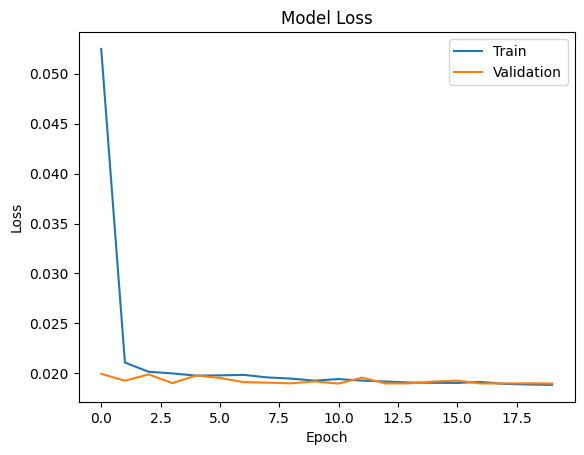

In [148]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

#### Forecasting Values

In [170]:
# y_true values
test_y_copy = np.repeat(test_y.reshape(-1,1), test_X.shape[-1], axis=-1)
true_temp = scaler.inverse_transform(test_y_copy)[:,0]

In [194]:
# Predicted values
train_predictions = model.predict(train_X)
test_predictions = model.predict(test_X)

# Reshape into 2D array
train_predictions = train_predictions.reshape(-1, data.shape[-1])
test_predictions = test_predictions.reshape(-1, data.shape[-1])

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [195]:
prediction_copies = np.repeat(train_predictions, 1, axis=-1)
predicted_temp = scaler.inverse_transform(prediction_copies)
predicted_temp

array([[21.719898],
       [21.726782],
       [21.725008],
       ...,
       [21.71742 ],
       [21.728594],
       [21.72585 ]], dtype=float32)

In [201]:
sacramento_temp[-168:]      # Last 7 days of September, 2016

,temp
mdct,
2016-09-24 00:00:00,23.4
2016-09-24 01:00:00,24.3
2016-09-24 02:00:00,23.8
2016-09-24 03:00:00,22.2
2016-09-24 04:00:00,21.9
...,...
2016-09-30 19:00:00,31.6
2016-09-30 20:00:00,31.2
2016-09-30 21:00:00,29.3


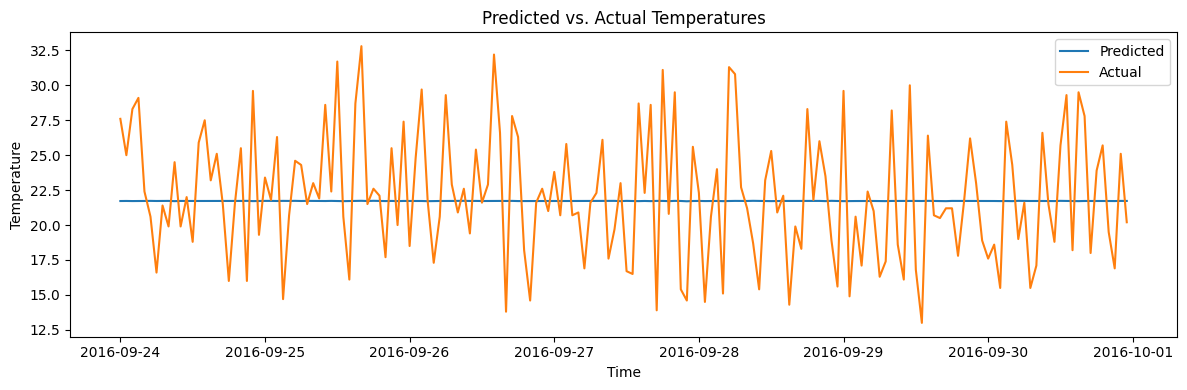

In [206]:
# Plotting predicted and actual temperatures from the past 7 days
plt.figure(figsize=(12,4))
plt.plot(sacramento_temp.index[-168:], predicted_temp[-168:], label='Predicted')
plt.plot(sacramento_temp.index[-168:], true_temp[-168:], label='Actual')
plt.title('Predicted vs. Actual Temperatures')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.tight_layout()
plt.show()

## <span style="color:Orange;"> VIII. Comparison </span>  <a name="comparison"></a>  
<i> Comparison between the results of the two specified models: ARIMA and Deep Learning Models, and assessing which model performs better in <b> Predicting and Classification </b> </i>  



## <span style="color:Orange;"> IX. Conclusion and Recommendation </span> <a name="conclusion"></a>  
`edit contents`